# Starter RNN LSTM 

In [100]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_absolute_error

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [2]:
data_source_dir = r'/home/jasonchandatascience/competition_prep/data/hourly_energy_consumption'

In [3]:
def GetPath(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [110]:
# had to edit permission using !chmod 644 *.csv for all csv files
df = pd.read_csv(GetPath('PJME_hourly.csv'), index_col=[0], parse_dates=[0])

In [73]:
scaler = sklearn.preprocessing.MinMaxScaler()

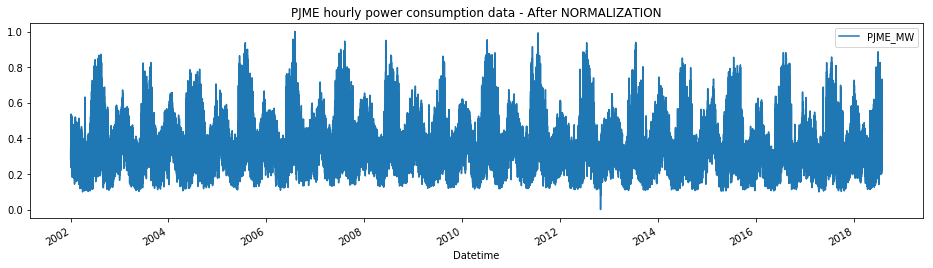

In [63]:
df.plot(figsize=(16,4),legend=True)

plt.title('PJME hourly power consumption data - After NORMALIZATION')

plt.show()

In [111]:
split_date = '01-Jan-2015'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

In [65]:
pjme_train.shape

(113927, 1)

In [66]:
pjme_test.shape

(31439, 1)

In [67]:
np.array([113927, 31439]) / df.shape[0]

array([0.78372522, 0.21627478])

In [120]:
train_df = df.iloc[:113927]
test_df = df.iloc[113927:]

In [77]:
train_df["PJME_MW"] = scaler.fit_transform(train_df["PJME_MW"].values.reshape(-1, 1))

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
test_df["PJME_MW"] = scaler.transform(test_df["PJME_MW"].values.reshape(-1, 1))

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
df_merged = pd.concat([train_df, test_df])

# Data Prep Function

In [84]:
def load_data(stock, seq_len, split):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[split:]             
    y_test = y_train[split:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:split]           
    y_train = y_train[:split]
    
    
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (split, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [85]:
X_train, y_train, X_test, y_test = load_data(df_merged, 20, 113927)

# Simple RNN Model

In [86]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 20, 40)            1680      
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 20, 40)            3240      
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_15 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total para

In [90]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=500)

Epoch 1/10
113927/113927 [==============================] - 14s 119us/step - loss: 0.1463
Epoch 2/10
113927/113927 [==============================] - 11s 99us/step - loss: 0.0343
Epoch 3/10
113927/113927 [==============================] - 11s 99us/step - loss: 0.0185
Epoch 4/10
113927/113927 [==============================] - 11s 99us/step - loss: 0.0111
Epoch 5/10
113927/113927 [==============================] - 11s 100us/step - loss: 0.0074
Epoch 6/10
113927/113927 [==============================] - 11s 99us/step - loss: 0.0056
Epoch 7/10
113927/113927 [==============================] - 11s 99us/step - loss: 0.0046
Epoch 8/10
113927/113927 [==============================] - 11s 100us/step - loss: 0.0039
Epoch 9/10
113927/113927 [==============================] - 11s 100us/step - loss: 0.0034
Epoch 10/10
113927/113927 [==============================] - 11s 100us/step - loss: 0.0031


In [91]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9542496427884055


In [112]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [122]:
mean_absolute_error(y_test, rnn_predictions)

0.021594774644201994

In [114]:
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
inv_pred = scaler.inverse_transform(rnn_predictions)

In [121]:
mean_absolute_percentage_error(test_df['PJME_MW'].values, inv_pred)

23.460460112197516

In [117]:
pjme_test['PJME_MW'].values.reshape(-1, 1)

array([[24305.],
       [23156.],
       [22514.],
       ...,
       [42402.],
       [40164.],
       [38608.]])

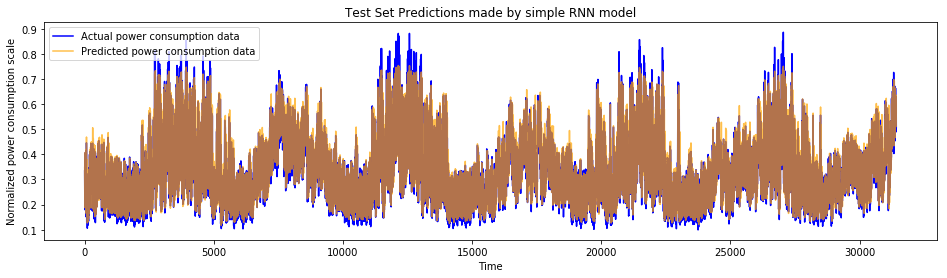

In [124]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Test Set Predictions made by simple RNN model")